In [2]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import pandas as pd
import getpass
import pydap

In [191]:
# show all output from cells
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # last_expr
pd.set_option('display.max_columns', None)

### EEZ shapefile

[Source 1](https://www.marineregions.org/downloads.php)

[Source 2](https://ows.emodnet-humanactivities.eu/geonetwork/srv/eng/catalog.search#/metadata/d4a3fede-b0aa-485e-b4b2-77e8e3801fd0)


In [3]:
eez = gpd.read_file(
    "../data/EMODnet_HA_OtherManagementAreas_EEZ_v11_20210506/EMODnet_HA_OtherManagementAreas_EEZ_v11_20210506.shp"
)

In [4]:
data_copy = eez.copy()
data_copy = eez.to_crs({"proj": "cea"})
eez["poly_area"] = data_copy["geometry"].area / 10**6  # in km^2

In [5]:
countries = [
    "Belgium",
    "Germany",
    "Denmark",
    "Estonia",
    "Spain",
    "Finland",
    "France",
    "Ireland",
    "Lithuania",
    "Latvia",
    "Netherlands",
    "Poland",
    "Portugal",
    "Sweden",
    "United Kingdom",
]

In [6]:
eezSDG14 = eez[eez.Territory.isin(countries)]
# we increase by one degree to be safe
boundsEEZ = (
    eezSDG14.total_bounds[0] - 1,
    eezSDG14.total_bounds[1] - 1,
    eezSDG14.total_bounds[2] + 1,
    eezSDG14.total_bounds[3] + 1,
)
boundsEEZ

(-17.073890430099198,
 33.877599219328545,
 29.208985437228193,
 68.08058834047961)

### Copernicus Marine Data
[Source](https://data.marine.copernicus.eu/product/MULTIOBS_GLO_BIO_CARBON_SURFACE_REP_015_008/description)

#### Download data from Copernicus
[Based on this guide](https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python)

In [7]:
USERNAME = "isaldivia1"
PASSWORD = getpass.getpass("Enter your password: ")
DATASET_ID = "dataset-carbon-rep-monthly"

In [8]:
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session

    cas_url = "https://cmems-cas.cls.fr/cas/login"
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()["CASTGC"])
    database = ["my", "nrt"]
    url = f"https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}"
    try:
        data_store = xr.backends.PydapDataStore(
            open_url(url, session=session, user_charset="utf-8")
        )  # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    except:
        url = f"https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}"
        data_store = xr.backends.PydapDataStore(
            open_url(url, session=session, user_charset="utf-8")
        )  # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

In [9]:
data_store = copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)
ds = xr.open_dataset(data_store)

#### Define functions

In [234]:
def slice_var(
    ds=xr.core.dataset.Dataset,
    variables=list,
    timerange=list(ds.time[-2:].values),
    bounds=list([0, 360, -90, 90]),
):
    """
    Slice variables to desired time and space
    Parameters
    ----------
    ds : xarray.core.dataset.Dataset
        Dataset containing variables to be sliced
    variables : list
        List of variables to be sliced
    timerange : list
        List of start and end dates to be sliced
    bounds : list
        List of bounds to be sliced
    """
    if any(ds.longitude > 180):
        # when longitude of product is 0-360
        varDict = {}
        for var in variables:
            varDict["{0}_East".format(var)] = ds[var].sel(
                time=slice(timerange[0], timerange[1]),
                latitude=slice(bounds[2], bounds[3]),
                longitude=slice(0, bounds[1]),
            )
            varDict["{0}_West".format(var)] = ds[var].sel(
                time=slice(timerange[0], timerange[1]),
                latitude=slice(bounds[2], bounds[3]),
                longitude=slice(359.5 + bounds[0], 359.5),
            )
            for varSlice in varDict.keys():
                varDict[varSlice] = varDict[varSlice].rio.set_spatial_dims(
                    x_dim="longitude", y_dim="latitude", inplace=True
                )
                varDict[varSlice].coords["longitude"] = (
                    varDict[varSlice].coords["longitude"] + 180
                ) % 360 - 180
                varDict[varSlice] = varDict[varSlice].sortby(
                    varDict[varSlice].longitude
                )
                varDict[varSlice] = varDict[varSlice].rio.write_crs(
                    "epsg:4326", inplace=True
                )
            varDict["{0}Copernicus".format(var)] = xr.concat(
                [varDict["{0}_West".format(var)], varDict["{0}_East".format(var)]],
                dim="longitude",
            )
    else:
        varDict = {}
        for var in variables:
            varDict["{0}Copernicus".format(var)] = ds[var].sel(
                time=slice("2012-01-01", "2021-12-15"),
                latitude=slice(bounds[2], bounds[3]),
                longitude=slice(bounds[0], bounds[1]),
            )
            varDict["{0}Copernicus".format(var)] = varDict[
                "{0}Copernicus".format(var)
            ].rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
            varDict["{0}Copernicus".format(var)] = varDict[
                "{0}Copernicus".format(var)
            ].rio.write_crs("epsg:4326", inplace=True)
    return varDict



def saveVar(varDict=dict):
    """
    Save variables as netcdf
    Parameters
    ----------
    varDict : dict
        Dictionary containing variables to be saved
    """
    for k in list(varDict.keys()):
            if "Copernicus" in k:
                print(f"Saving {k} as netcdf")
                varDict[k].to_netcdf(f"../data/{k}.nc")
            else:
                varDict.pop(k)


def yearData(varDict=dict, years=list):
    """
    Create dictionary of variables by year
    Parameters
    ----------
    varDict : dict
        Dictionary containing variables to be saved
    years : list    
        List of years to be sliced
    """
    yearVarDict = {}
    for k in list(varDict.keys()):
        yearVarDict[k] = {}
        for year in years:
            yearVarDict[k][str(year)] = varDict[k].sel(
                time=slice("{0}-01-01".format(year), "{0}-12-31".format(year))
            ).mean(dim="time")
    return yearVarDict

def clipEEZ(years=list, countries=list, varDict=dict):
    """
    Clip variables gridded data to EEZs
    Parameters
    ----------
    years : list
        List of years to calculate mean
    countries : list
        List of countries to be clipped
    varDict : list
        List of variables to be clipped
    """
    eezVariables = {}
    for var in varDict:
        varYear = {}
        for year in years:
            varYear["{0}".format(year)] = varDict['{0}'.format(var)].sel(
                time=slice("{0}-01-01".format(year), "{0}-12-31".format(year))
            ).mean(dim="time")

        varCountryYear = {}
        for year in years:
            varCountryYear["{0}".format(year)] = {}
            for country in countries:
                varCountryYear["{0}".format(year)]["{0}".format(country)] = {}

        for k, v in varYear.items():
            varYear[k] = varYear[k].rio.set_spatial_dims(
                x_dim="longitude", y_dim="latitude", inplace=True
            )
            for country in countries:
                varCountryYear["{0}".format(k)][country] = (
                    varYear[k]
                    .rio.clip(
                        eezSDG14[eezSDG14.Territory == country].geometry.apply(mapping),
                        eezSDG14.crs,
                    )
                    .mean()
                    .values
                )
        eezVariables["{0}".format(var)] = varCountryYear
    return eezVariables

def plot(varDict=dict, years = list):
    """
    Plot variables
    Parameters
    ----------
    variables : list
        List of variables to be plotted
    years : list
        List of years to be plotted
    """
    for k in list(varDict.keys()):   
        minVal = varDict[k]['{}'.format(years[0])].variable.min().values
        maxVal = varDict[k]['{}'.format(years[0])].variable.max().values
        for year in years:
            if varDict[k][str(year)].min().values < minVal:
                minVal = varDict[k][str(year)].variable.min().values
            if varDict[k][str(year)].max().values > maxVal:
                maxVal = varDict[k][str(year)].variable.max().values
        title = varDict[k]['{}'.format(years[0])].name
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for i, year in enumerate(years):
            varDict[k][str(year)] = varDict[k][str(year)].rio.clip(
                eezSDG14.geometry.apply(mapping), eezSDG14.crs
            )
            varDict[k][str(year)].plot(ax=ax[i], cmap="viridis", vmin=minVal, vmax=maxVal)
            eezSDG14.plot(ax=ax[i], color="none", edgecolor="black")
            ax[i].set_title(year)
        fig.suptitle(title)
        plt.tight_layout()
        plt.savefig("../output/figs/{0}.png".format(k), dpi=300)
        plt.show()

#### Make calculations and plot

In [160]:
variables = ["ph", "ph_uncertainty"]
timerange = ['2012-01-01','2021-12-31']
varCopernicus = slice_var(ds=ds, variables=variables, timerange=timerange, bounds=boundsEEZ)
saveVar(varCopernicus)
varCopernicus.keys()

Saving phCopernicus as netcdf
Saving ph_uncertaintyCopernicus as netcdf


dict_keys(['phCopernicus', 'ph_uncertaintyCopernicus'])

In [216]:
varCopernicus['phCopernicus'].long_name

'pH on total scale'

In [163]:
years=[2012,2016,2021]
varCountryYear = clipEEZ(years = years,countries = countries,varDict=varCopernicus)
varCountryYear.keys()

dict_keys(['phCopernicus', 'ph_uncertaintyCopernicus'])

In [175]:
yearVarDict = yearData(varDict=varCopernicus)

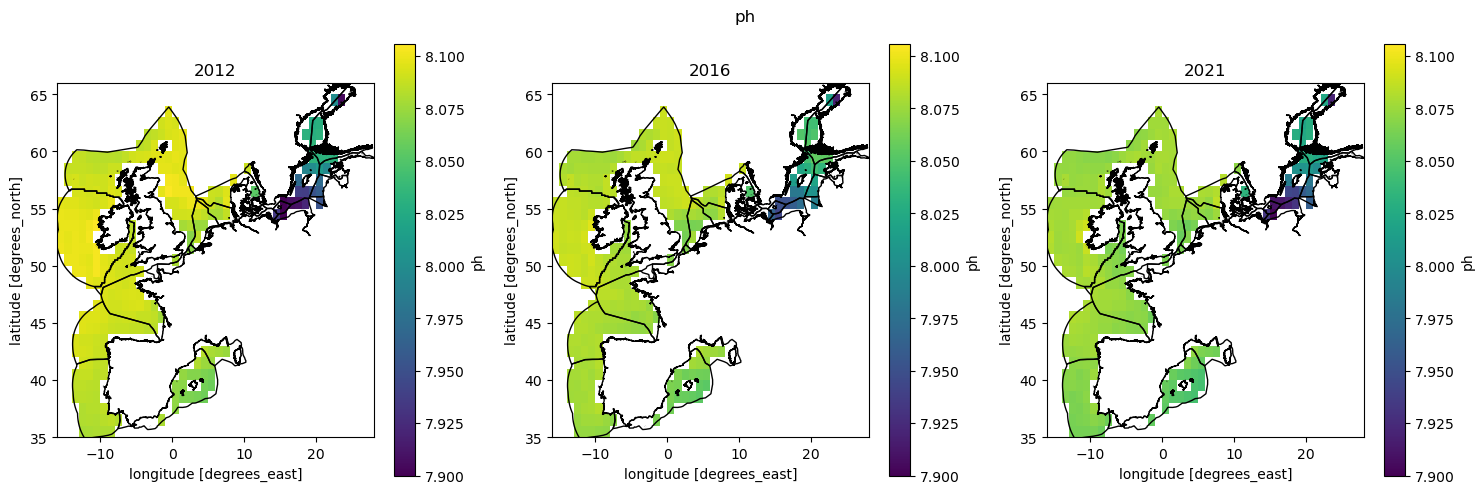

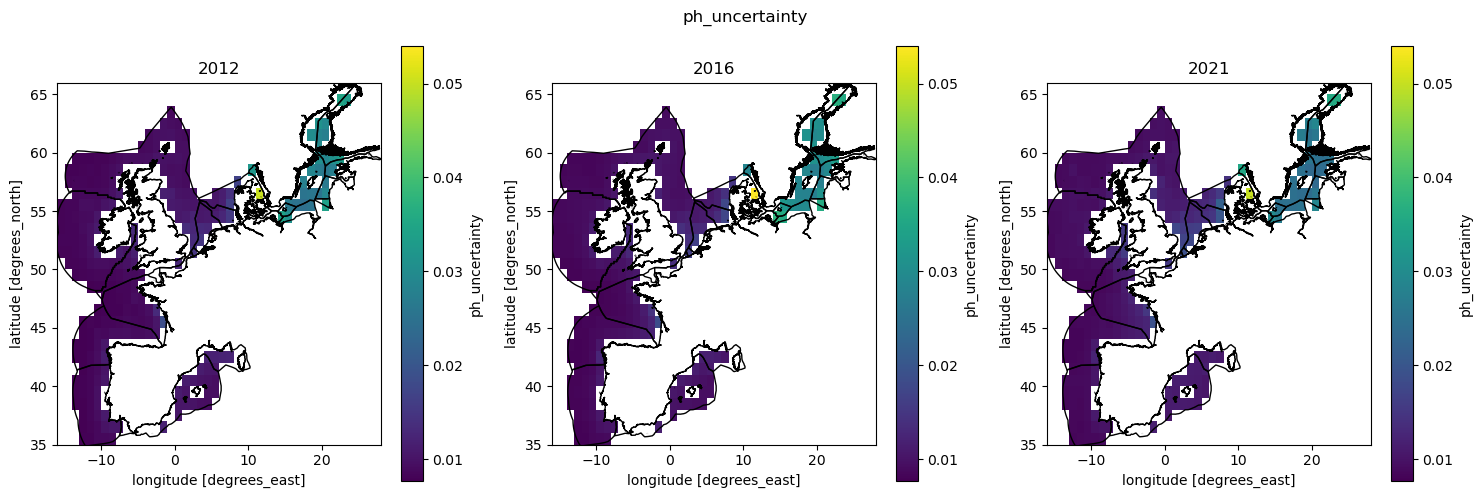

In [235]:
plot(yearVarDict, years=['2012','2016','2021'])

In [168]:
for var in varCountryYear.keys():
    varDf = pd.DataFrame(varCountryYear[var])
    varDf.to_csv('../data/'+var+'.csv')
    print(var,varDf)

phCopernicus                      2012       2016       2021
Belgium          8.070179   8.066542   8.063813
Germany          8.055145   8.054312   8.044487
Denmark          8.065767   8.064152   8.055584
Estonia          8.004305   8.038195   8.004012
Spain            8.082115   8.072526   8.066342
Finland          8.016771   8.034461   8.012807
France           8.087642    8.07798    8.07077
Ireland          8.096759   8.086586   8.077492
Lithuania       7.9523606  7.9881988  7.9607396
Latvia           7.961943   8.010791  7.9702873
Netherlands      8.084946   8.074646   8.068349
Poland           7.910485  7.9586277  7.9171433
Portugal         8.083828   8.076773      8.067
Sweden           7.989894   8.017664   7.994139
United Kingdom   8.091344  8.0825405    8.07373
ph_uncertaintyCopernicus                        2012         2016          2021
Belgium         0.014681631  0.016017746   0.018983005
Germany          0.01688373  0.018169543   0.018222071
Denmark         0.018668527  

### NOAA data
[Source](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0220059)

File is 1,4 GB

In [28]:
noaaPH = xr.open_dataset("../data/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc")

In [29]:
noaaPH = noaaPH.sel(
    lon=slice(boundsEEZ[0], boundsEEZ[2]), lat=slice(boundsEEZ[1], boundsEEZ[3])
)

In [30]:
years = [2012, 2016, 2021]
phYear = {}
for year in years:
    phYear["{0}".format(year)] = noaaPH.ph_total.sel(
        time=slice("{0}-01-01".format(year), "{0}-12-31".format(year))
    ).mean(dim="time")

In [31]:
phCountry = {}
for year in years:
    phCountry["{0}".format(year)] = {}
    for country in countries:
        phCountry["{0}".format(year)]["{0}".format(country)] = {}

In [32]:
for k, v in phYear.items():
    phYear[k] = phYear[k].rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    phYear[k] = phYear[k].rio.write_crs("epsg:4326", inplace=True)
    for country in countries:
        phCountry["{0}".format(k)][country] = (
            phYear[k]
            .rio.clip(
                eezSDG14[eezSDG14.Territory == country].geometry.apply(mapping),
                eezSDG14.crs,
            )
            .mean()
            .values
        )

In [33]:
phData = pd.DataFrame(phCountry)
phData.to_csv("../data/phDataNOAA.csv")
phData

,2012,2016,2021
Belgium,8.066332,8.057062,nan
Germany,8.067738,8.070016,8.077536
Denmark,8.085134,8.0792885,8.070046
Estonia,8.02835,8.063891,8.037472
Spain,8.090724,8.081096,8.072152
Finland,8.027017,8.057165,8.027941
France,8.093457,8.0852,8.074092
Ireland,8.0959425,8.085807,8.075813
Lithuania,8.03648,8.073564,8.051622
Latvia,8.014241,8.056093,8.028847


In [34]:
minVal = phYear["2012"].min().values
maxVal = phYear["2012"].max().values
for year in years:
    if phYear[str(year)].min().values < minVal:
        minVal = phYear[str(year)].min().values
    if phYear[str(year)].max().values > maxVal:
        maxVal = phYear[str(year)].max().values
minVal, maxVal

(array(7.97603655), array(8.15105629))

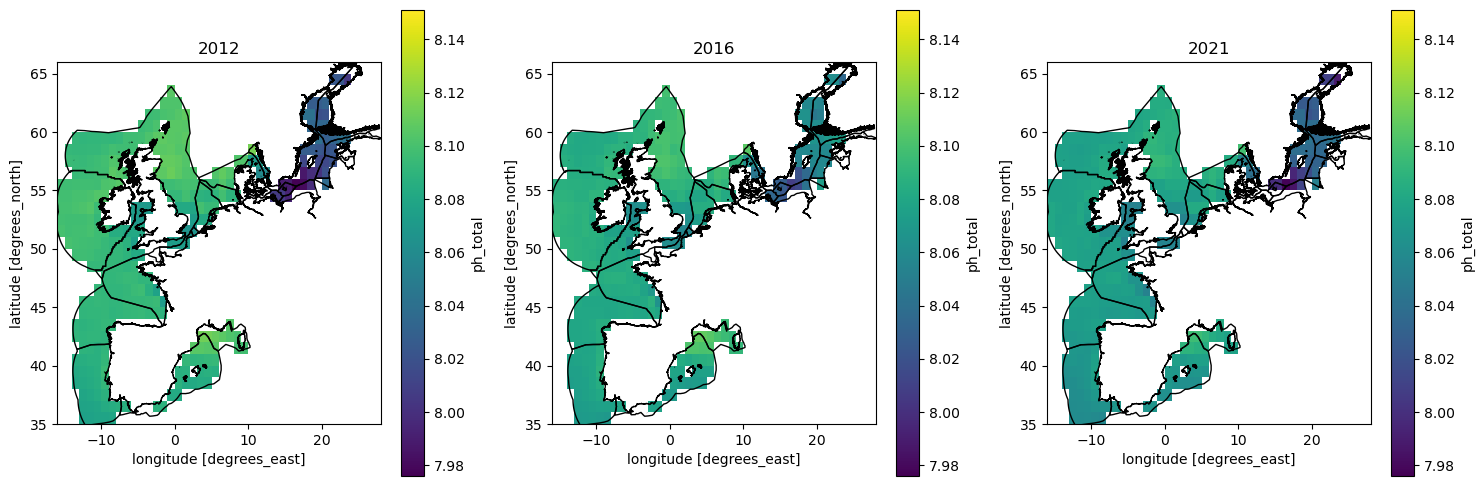

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, year in enumerate(years):
    phYear[str(year)] = phYear[str(year)].rio.clip(
        eezSDG14.geometry.apply(mapping), eezSDG14.crs
    )
    phYear[str(year)].plot(ax=ax[i], cmap="viridis", vmin=minVal, vmax=maxVal)
    eezSDG14.plot(ax=ax[i], color="none", edgecolor="black")
    ax[i].set_title(year)
plt.tight_layout()
plt.savefig("../output/figs/phNOAA.pdf")

### Bin

In [ ]:
# # when downloading sliced years from Copernicus viewer
# years = [2012, 2016, 2021]
# ph = {}
# for year in years:
#     ph["{0}".format(year)] = xr.open_dataset("../data/pH{0}.nc".format(year))

# phCountryGrid = {}
# for year in years:
#     phCountryGrid["{0}".format(year)] = {}
#     for country in countries:
#         phCountryGrid["{0}".format(year)]["{0}".format(country)] = {}
# phCountryVal = phCountryGrid.copy()

# for k, v in ph.items():
#     ph[k] = v.mean(dim="time")
#     ph[k] = ph[k].rio.set_spatial_dims(
#         x_dim="longitude", y_dim="latitude", inplace=True
#     )
#     ph[k] = ph[k].rio.write_crs("epsg:4326", inplace=True)
#     for country in countries:
#         phCountryGrid["{0}".format(k)][country] = ph[k].rio.clip(
#             eezSDG14[eezSDG14.Territory == country].geometry.apply(mapping),
#             eezSDG14.crs,
#             drop=False,
#         )
#         phCountryVal["{0}".format(k)][country] = (
#             phCountryGrid["{0}".format(k)][country].ph.mean().values
#         )